In [10]:
import os

import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

C:\Users\HoJinLee\AppData\Local\Temp\ipykernel_29432\1920170836.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [11]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)


        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [12]:
model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=10,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


9913344it [00:01, 5740179.87it/s]                             


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



29696it [00:00, 29508185.64it/s]         


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



1649664it [00:00, 12682873.40it/s]                            


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



5120it [00:00, ?it/s]                   
Missing logger folder: logs/lightning_logs


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.20it/s]

c:\Users\HoJinLee\anaconda3\envs\pyl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\HoJinLee\anaconda3\envs\pyl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 235/235 [00:13<00:00, 17.36it/s, loss=0.168, v_num=0, val_loss=0.136, val_acc=0.957]


In [13]:
trainer.test()

c:\Users\HoJinLee\anaconda3\envs\pyl\lib\site-packages\pytorch_lightning\trainer\trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs\version_0\checkpoints\epoch=9-step=2150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/lightning_logs\version_0\checkpoints\epoch=9-step=2150.ckpt
c:\Users\HoJinLee\anaconda3\envs\pyl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this 

Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 15.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9571999907493591
        test_loss           0.13991422951221466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13991422951221466, 'test_acc': 0.9571999907493591}]

In [14]:
trainer.fit(model)

c:\Users\HoJinLee\anaconda3\envs\pyl\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory logs/lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.430300,0.8828,NaN,NaN
1,0.298128,0.9104,NaN,NaN
2,0.249034,0.9232,NaN,NaN
3,0.217908,0.9324,NaN,NaN
4,0.195126,0.9376,NaN,NaN
5,0.177727,0.9434,NaN,NaN
6,0.165052,0.9468,NaN,NaN
7,0.152659,0.9520,NaN,NaN
8,0.144242,0.9540,NaN,NaN


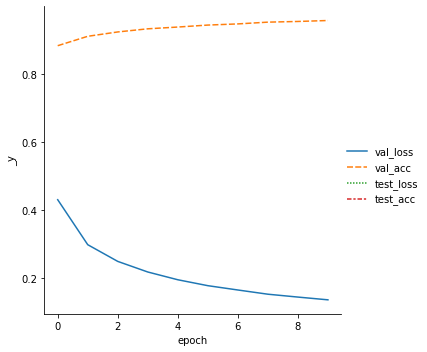

In [16]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all"))
sn.relplot(data=metrics, kind="line")